# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 6

In [4]:
%reload_ext autoreload
%autoreload 2

In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, ReduceLROnPlateau, CyclicLR
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms.v2 import Compose, Resize, ToDtype, ToImage

plt.style.use('fivethirtyeight')

In [23]:
from data_generation.rps import download_rps
from plots.chapter6 import figure1, figure2, figure7, figure8, figure9, figure11, figure15, figure17, figure21, figure26, figure28
from plots.chapter6 import ma_vs_ewma, contour_data, plot_paths, plot_losses, plot_scheduler
from stepbystep.v1 import StepByStep

# Rock, Paper, Scissors

## Rock Paper Scissors Dataset

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset). 

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

In [5]:
# This may take a couple of minutes...
download_rps()

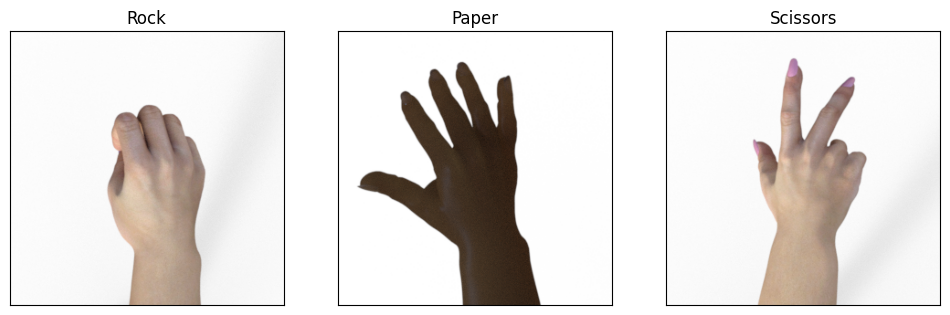

In [7]:
fig = figure1()

# Data Preparation

## ImageFolder

In [4]:
temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

In [12]:
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

## Standardization

In [5]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [ ]:
# @staticmethod
# def statistics_per_channel(images, labels)

In [6]:
first_images, first_labels = next(iter(temp_loader))
StepByStep.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [18]:
results = StepByStep.loader_apply(temp_loader, StepByStep.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [ ]:
# @staticmethod
# def make_normalizer(loader)

In [7]:
normalizer = StepByStep.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.8502), tensor(0.8215), tensor(0.8116)], std=[tensor(0.2089), tensor(0.2512), tensor(0.2659)], inplace=False)

### The Real Datasets

In [8]:
composer = Compose([Resize(28),
                    ToImage(),
                    ToDtype(torch.float32, scale=True),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

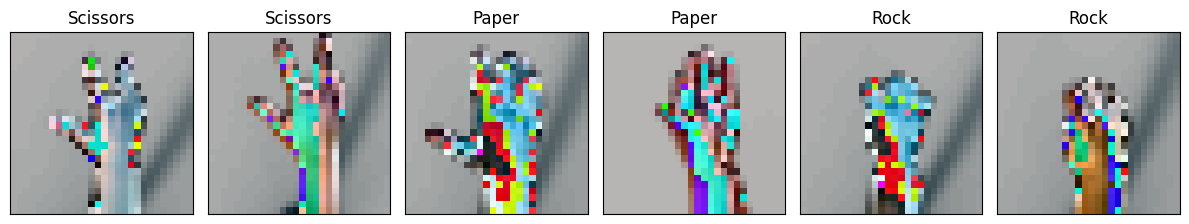

In [26]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

## Convolutions Over Multiple Channels

![](images/3channel1.png)

![](images/3channel2.png)

In [27]:
regions = np.array([[[[5, 0, 8],
                      [1, 9, 5],
                      [6, 0, 2]],
                     [[0, 5, 4],
                      [8, 1, 9],
                      [4, 8, 1]],
                     [[4, 2, 0],
                      [6, 3, 0],
                      [5, 2, 8]]]])
regions.shape

(1, 3, 3, 3)

In [28]:
three_channel_filter = np.array([[[[0, 3, 0],
                                   [1, 0, 1],
                                   [2, 1, 0]],
                                  [[2, 1, 0],
                                   [0, 3, 1],
                                   [1, -1, 0]],
                                  [[0, 1, 3],
                                   [-1, -2, 0],
                                   [2, 0, 1]]]])
three_channel_filter.shape

(1, 3, 3, 3)

In [30]:
result = F.conv2d(torch.as_tensor(regions), torch.as_tensor(three_channel_filter))
result, result.shape

(tensor([[[[39]]]]), torch.Size([1, 1, 1, 1]))

![](images/3channel_filters1.png)

## Fancier Model

In [29]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p

        # Create the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=3)
        # Create the linear (fully-connected) layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        # Create dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature@13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x
    
    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

## Dropout

In [31]:
dropping_model = nn.Sequential(nn.Dropout(p=.5))

In [32]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [33]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

![](images/dropout_paper.png)

In [34]:
output_train / spaced_points

tensor([0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 2.])

In [35]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

In [36]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [37]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [38]:
torch.manual_seed(17)
p = .5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=.5), 
                                         weight=torch.ones(11), 
                                         bias=torch.tensor(0)) 
                                for _ in range(1000)])

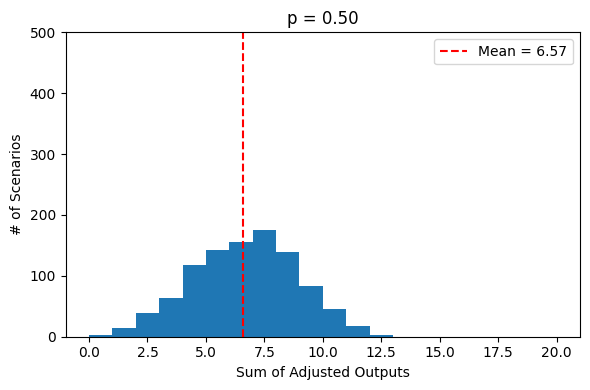

In [41]:
fig = figure7(p, distrib_outputs)

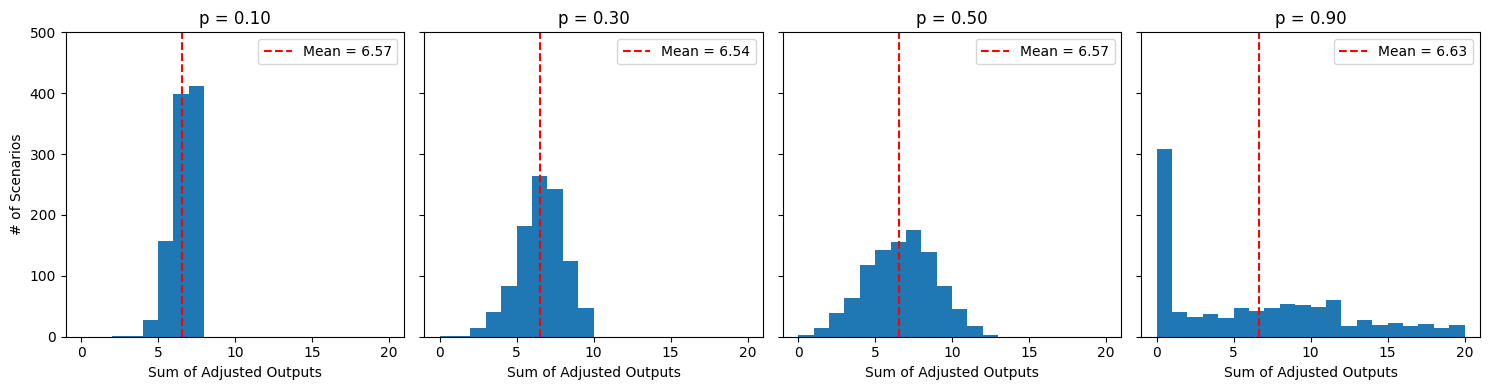

In [44]:
fig = figure8()

### Two-Dimensional Dropout

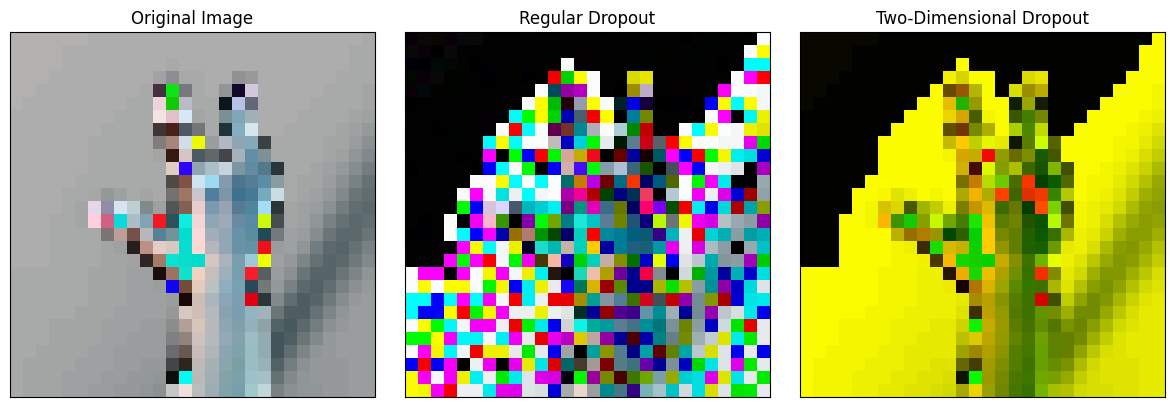

In [47]:
fig = figure9(first_images)

## Model Configuration

In [53]:
lr = 3e-4

torch.manual_seed(13)

model_cnn2 = CNN2(n_feature=5, p=.3)

ce_loss_fn = nn.CrossEntropyLoss(reduction='mean')

optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=lr)

## Model Training

In [54]:
sbs_cnn2 = StepByStep(model_cnn2, ce_loss_fn, optimizer_cnn2)
sbs_cnn2.set_loaders(train_loader, val_loader)
sbs_cnn2.train(10)

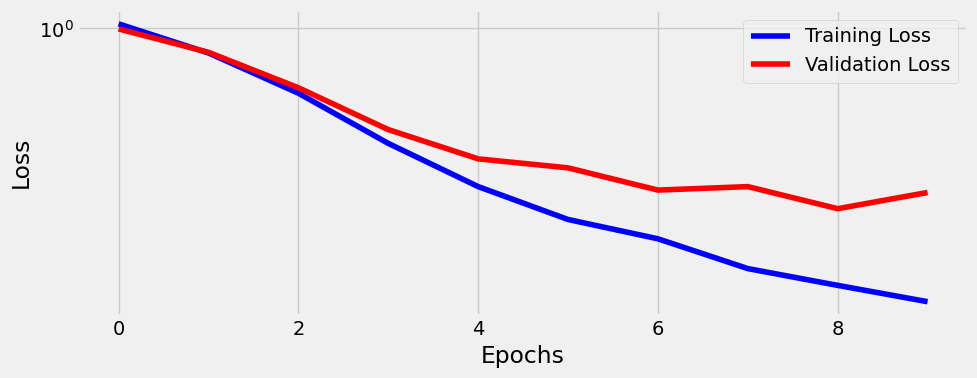

In [58]:
fig = sbs_cnn2.plot_losses()

### Accuracy

In [59]:
StepByStep.loader_apply(val_loader, sbs_cnn2.correct)

tensor([[ 93, 124],
        [119, 124],
        [115, 124]])

### Regularizing Effect

In [67]:
lr = 3e-4

torch.manual_seed(13)

# Model configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=.0)
ce_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=lr)

# Model training
sbs_cnn2_nodrop = StepByStep(model_cnn2_nodrop, ce_loss_fn, optimizer_cnn2_nodrop)
sbs_cnn2_nodrop.set_loaders(train_loader, val_loader)
sbs_cnn2_nodrop.train(10)

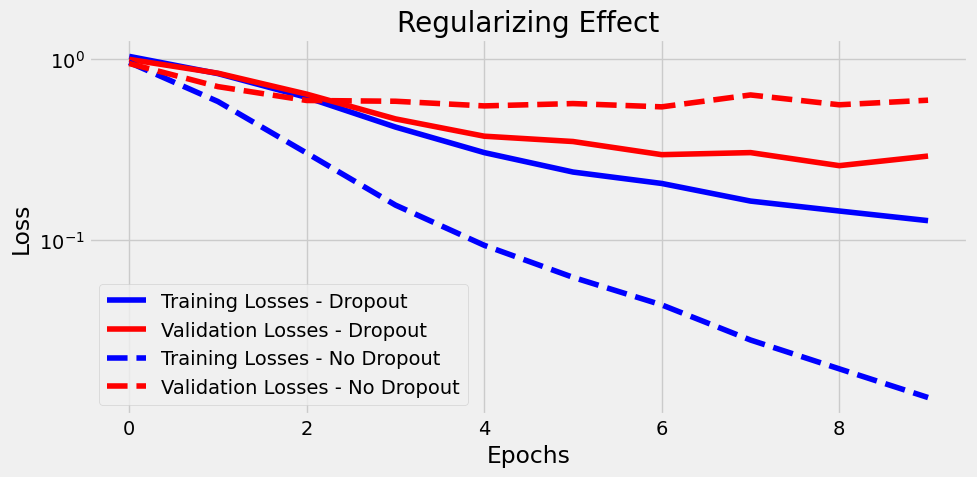

In [68]:
fig = figure11(sbs_cnn2.losses, sbs_cnn2.val_losses, sbs_cnn2_nodrop.losses, sbs_cnn2_nodrop.val_losses)

In [69]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2_nodrop.correct).sum(axis=0), 
    StepByStep.loader_apply(val_loader, sbs_cnn2_nodrop.correct).sum(axis=0)
)

tensor([2520, 2520]) tensor([293, 372])


In [70]:
print(
    StepByStep.loader_apply(train_loader, sbs_cnn2.correct).sum(axis=0),
    StepByStep.loader_apply(val_loader, sbs_cnn2.correct).sum(axis=0)
)

tensor([2504, 2520]) tensor([327, 372])


### Visualizing Filters

In [74]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

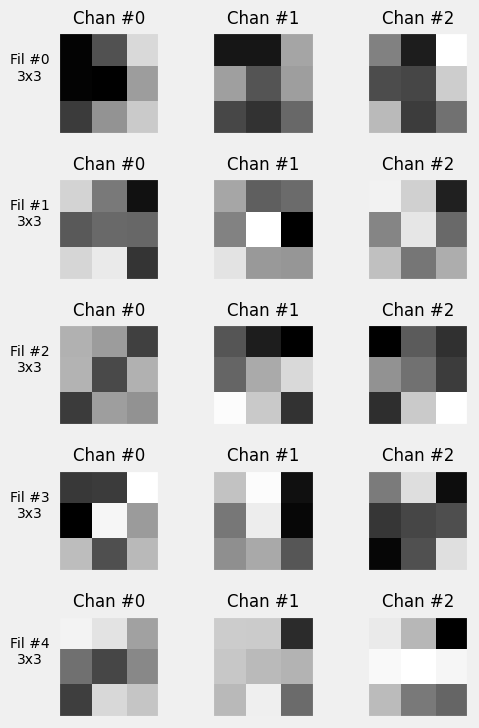

In [79]:
fig = sbs_cnn2.visualize_filters('conv1')

In [80]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

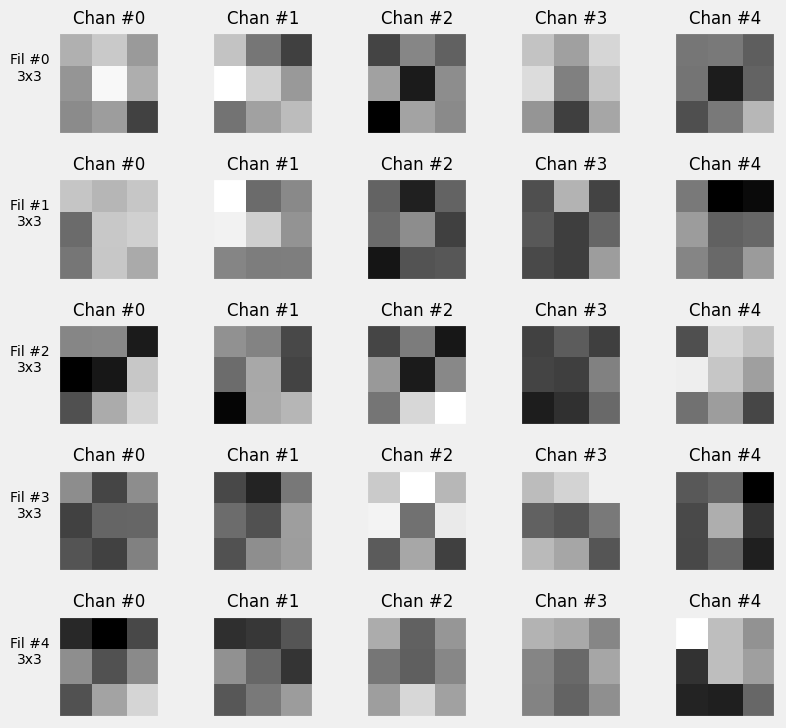

In [81]:
fig = sbs_cnn2.visualize_filters('conv2')

## Learning Rates

### Finding LR

In [7]:
def make_lr_fn(start_lr, end_lr, n_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / n_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / n_iter
        def lr_fn(iteration):
            return np.exp(factor) ** iteration
    return lr_fn

In [18]:
start_lr = 0.01
end_lr = 0.2
n_iter = 10

In [24]:
lr_fn_exp = make_lr_fn(start_lr, end_lr, n_iter, step_mode='exp')
lr_fn_exp(np.arange(n_iter + 1))

array([ 1.        ,  1.34928285,  1.8205642 ,  2.45645605,  3.31445402,
        4.47213595,  6.03417634,  8.14181063, 10.98560543, 14.82268898,
       20.        ])

In [20]:
lr_fn_linear = make_lr_fn(start_lr, end_lr, n_iter, step_mode='linear')
lr_fn_linear(np.arange(n_iter + 1))

array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ])

In [25]:
start_lr * lr_fn_exp(np.arange(n_iter + 1))

array([0.01      , 0.01349283, 0.01820564, 0.02456456, 0.03314454,
       0.04472136, 0.06034176, 0.08141811, 0.10985605, 0.14822689,
       0.2       ])

In [32]:
start_lr = 0.01
end_lr = 0.1
n_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, n_iter, step_mode='exp')

start_lr * lr_fn(np.arange(n_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [ ]:
dummy_model = CNN2(n_feature=5, p=.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_lr_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)  # from torch.optim.lr_scheduler import LambdaLR

In [30]:
dummy_optimizer.step()
dummy_lr_scheduler.step()

In [33]:
dummy_lr_scheduler.get_last_lr()

[np.float64(0.012589254117941673)]

In [ ]:
# def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None)

In [35]:
lr = .0003
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=.3)
ce_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=lr)

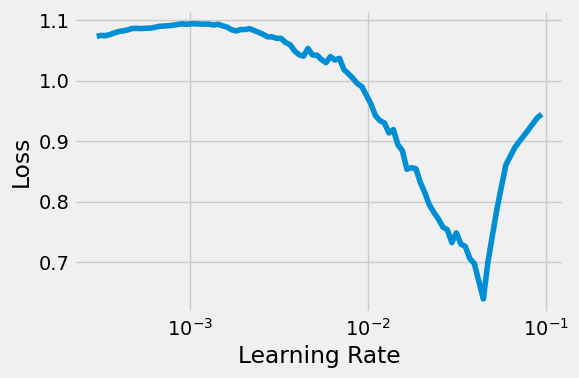

In [42]:
sbs_new = StepByStep(new_model, ce_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=.1, n_iter=100)

In [ ]:
# def set_optimizer(self, optimizer)

In [50]:
new_optimizer = optim.Adam(new_model.parameters(), lr=.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

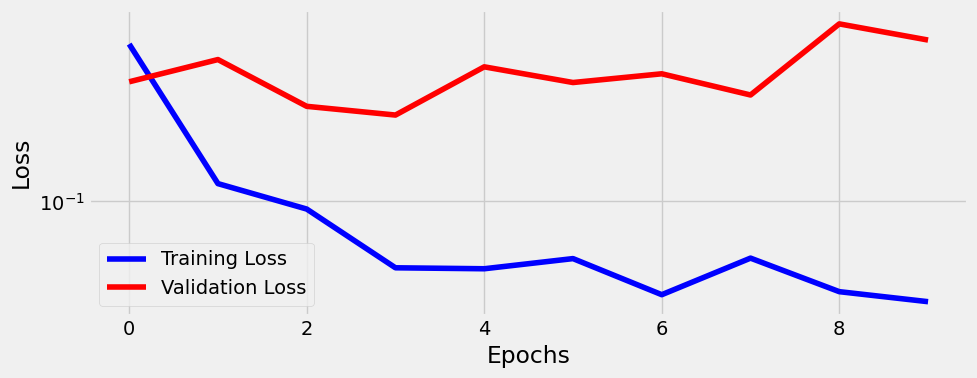

In [51]:
fig = sbs_new.plot_losses()

In [52]:
sbs_new.train(10)

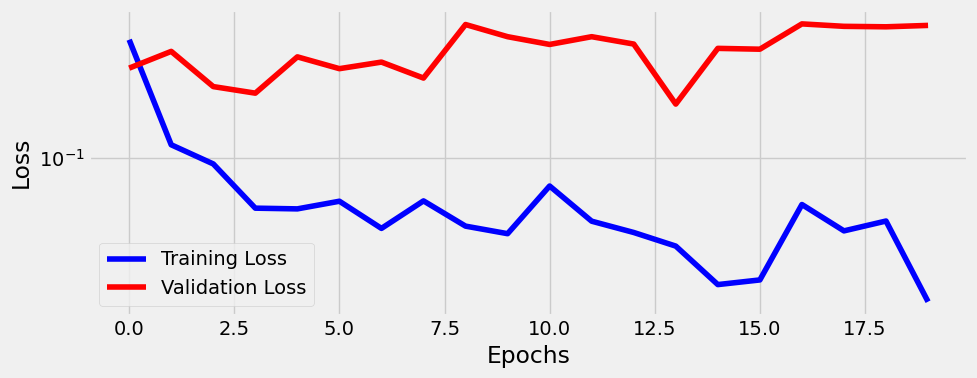

In [53]:
fig = sbs_new.plot_losses()

### LRFinder

In [54]:
%pip install --quiet torch-lr-finder

from torch_lr_finder import LRFinder

Note: you may need to restart the kernel to use updated packages.


/zdata/Github/zpytorch/lib/python3.12/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.36it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.01E-02


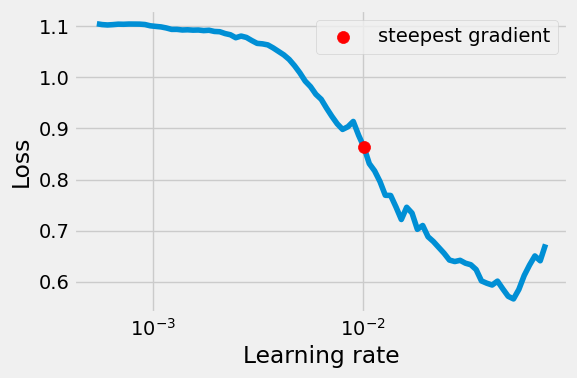

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=.3)
ce_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=.0003)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, ce_loss_fn, device)
lr_finder.range_test(train_loader, end_lr=.1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

### Adaptive Learning Rate

#### Moving Average (MA)

$$
\large
\text{MA}_t(\text{periods}, x) = \frac{1}{\text{periods}}(x_t + x_{t-1} + \ldots + x_{t-\text{periods}+1})
$$

$$
\large
\text{average age}_{\text{MA}} = \frac{1+2+\cdots+\text{periods}}{\text{periods}} = \frac{\text{periods}+1}{2}
$$

#### EWMA

$$
\Large
\begin{array}{ccrcrc}
\text{EWMA}_t(\alpha, x) &= &\alpha \ x_t &+ &(1-\alpha) \ \text{EWMA}_{t-1}(\alpha, x)
\\
\text{EWMA}_t(\beta, x) &= &(1-\beta) \ x_t &+ &\beta \ \text{EWMA}_{t-1}(\beta, x)
\end{array}
$$

$$
\large
\begin{array}{ccccccl}
\text{EWMA}_t(\alpha, x) &= &\alpha x_t &+& (1-\alpha)\ (\alpha x_{t-1} &+& (1-\alpha)\ \ \text{EWMA}_{t-2}(\alpha, x))
\\
&= &\alpha x_t &+& (1-\alpha)\ \ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} \ + \ \ldots
\\
&= &\ (1-\alpha)^0 \alpha x_{t-0} &+& (1-\alpha)^1\ \alpha x_{t-1} &+& (1-\alpha)^2 \alpha x_{t-2} \ + \ \ldots
\\
&= &\alpha \ ((1-\alpha)^0 \ x_{t-0} &+& (1-\alpha)^1\ \ \ x_{t-1} &+& (1-\alpha)^2\ \ x_{t-2} \ + \ \ldots)
\end{array}
$$

$$
\large
\text{EWMA}_t(\alpha, x) = \alpha \sum_{\text{lag}=0}^{T-1}\underbrace{(1-\alpha)^{\text{lag}}}_{\text{weight}} x_{t-\text{lag}}
$$

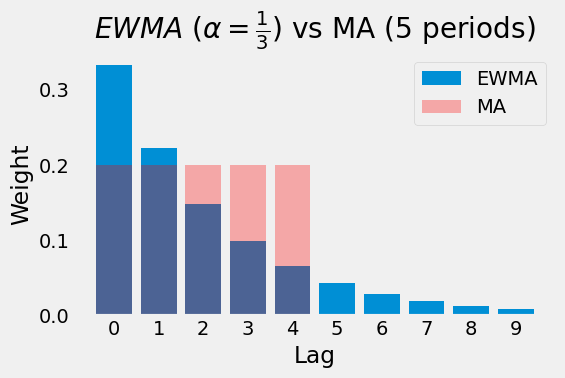

In [62]:
fig = figure15()

$$
\large
\text{average age}_{\text{EWMA}} = \alpha \sum_{\text{lag}=0}^{T-1}(1-\alpha)^{\text{lag}} (\text{lag}+1) \approx \frac{1}{\alpha}
$$

In [71]:
alpha = 1/3; T = 94
avg_age_EWMA = .0
for t in range(1, T + 1):
    lag = t - 1
    avg_age_EWMA += alpha * ((1 - alpha) ** lag * (lag + 1))
    if t < 20 or t > 80:
        print(avg_age_EWMA)
    if t == 20:
        print('...')

0.3333333333333333
0.7777777777777778
1.2222222222222223
1.617283950617284
1.946502057613169
2.209876543209877
2.4147233653406497
2.5707971345831435
2.6878524615150137
2.7745601110941767
2.838145720785563
2.884389800561117
2.917788302621239
2.9417667143567114
2.9588941513106204
2.9710736620334
2.979700815462036
2.9857905708234256
2.990075954225885
...
2.9999999999995444
2.9999999999996936
2.999999999999794
2.999999999999862
2.9999999999999076
2.9999999999999387
2.9999999999999596
2.999999999999974
2.999999999999983
2.9999999999999893
2.999999999999994
2.999999999999997
2.9999999999999987
3.0


$$
\large
\text{average age} = \frac{\text{periods} + 1}{2} = \frac{1}{\alpha} \implies \alpha = \frac{2}{\text{periods}+1};\ \text{periods} = \frac{2}{\alpha}-1
$$

In [17]:
def EWMA(past_value, current_value, alpha):
    return alpha * current_value + (1 - alpha) * past_value

In [18]:
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha=alpha)
        result.append(new_value)
    
    return np.array(result)

$$
\large \text{Bias Corrected EWMA}_t(x, \beta) = \frac{1}{1 - \beta^t}\text{EWMA}_t(x, \beta)
$$

In [19]:
def correction(averaged_value, beta, step):
    '''
    Parameters:
    averaged_value: the EWMA value needs to be corrected
    beta: 1 - alpha
    step: 1 for the first value, 2 for the second value, and so on
    '''
    return averaged_value / (1 - beta ** step)

In [20]:
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha
    result = [correction(v, beta, i + 1) for i, v in enumerate(ewma)]

    return np.array(result)

In [77]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1, -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])
temperatures.shape

(30,)

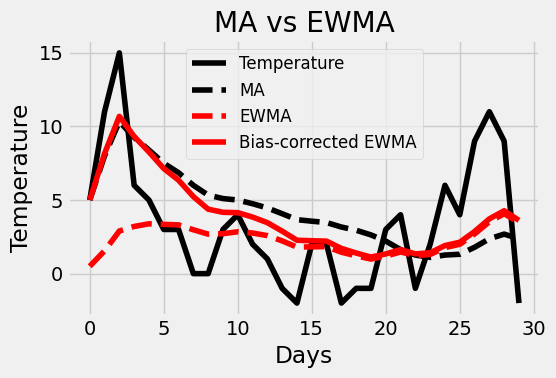

In [80]:
fig = ma_vs_ewma(temperatures, periods=19)

#### EWMA Meets Gradients

$$
\large \text{adapted-gradient}_t = \frac{\text{Bias Corrected EWMA}_t(\beta_1, \text{gradients})}{\sqrt{\text{Bias Corrected EWMA}_t(\beta_2, \text{gradients}^2)}+\epsilon}
$$

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\end{aligned}
$$

#### Adam

In [ ]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=.0125, betas=(0.9, 0.999), eps=1e-8)

#### Visualizing Adapted Gradients

In [11]:
%run -i data_generation/simple_linear_regression.py
%run -i data_preparation/v2.py

In [12]:
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=.1)
loss_fn = nn.MSELoss(reduction='mean')

In [ ]:
# def capture_gradients(self, layers_to_hook)

In [16]:
sbs_adam = StepByStep(model, loss_fn, optimizer)
sbs_adam.set_loaders(train_loader, val_loader)
sbs_adam.capture_gradients('linear')
sbs_adam.train(10)
sbs_adam.remove_hooks()

In [21]:
gradients = np.array(sbs_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

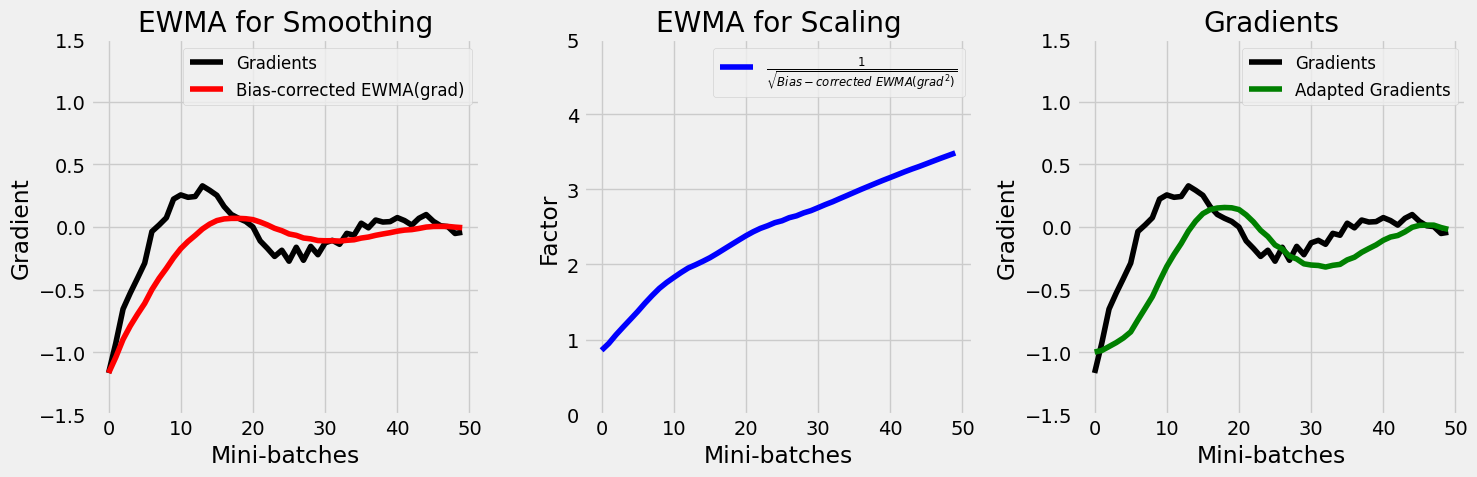

In [23]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

In [24]:
optimizer.state_dict()

{'state': {0: {'step': tensor(50.),
   'exp_avg': tensor([[-0.0055]], device='cuda:0'),
   'exp_avg_sq': tensor([[0.0040]], device='cuda:0')},
  1: {'step': tensor(50.),
   'exp_avg': tensor([0.0525], device='cuda:0'),
   'exp_avg_sq': tensor([0.0104], device='cuda:0')}},
 'param_groups': [{'lr': 0.1,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [25]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[1.9344]], device='cuda:0')),
             ('linear.bias', tensor([1.0099], device='cuda:0'))])

In [27]:
calc_ewma(gradients, 19)[-1], calc_ewma(np.power(gradients, 2), 1999)[-1]

(np.float64(-0.005502247372857658), np.float64(0.004014803099570996))

In [ ]:
    # def capture_parameters(self, layers_to_hook):

In [ ]:
        # self.learning_rates = []

In [19]:
def compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader=None, schedulers=None, layers_to_hook=None, n_epochs=50):
    results = {}
    model_state = deepcopy(model.state_dict())

    for desc, options in optimizers.items():
        model.load_state_dict(model_state)
        optimizer = options['class'](model.parameters(), **options['parms'])

        sbs = StepByStep(model, loss_fn, optimizer)
        sbs.set_loaders(train_loader, val_loader)

        try:
            if schedulers is not None:
                sched = schedulers[desc]
                scheduler = sched['class'](optimizer, **sched['parms'])
                sbs.set_lr_scheduler(scheduler)
        except KeyError:
            pass

        sbs.capture_parameters(layers_to_hook)
        sbs.capture_gradients(layers_to_hook)
        sbs.train(n_epochs)
        sbs.remove_hooks()

        parms = deepcopy(sbs._parameters)
        grads = deepcopy(sbs._gradients)

        lrs = sbs.learning_rates[:]
        if not lrs:
            lrs = [list(map(lambda p: p['lr'], optimizer.state_dict()['param_groups']))] * n_epochs

        results.update({desc: {'parms': parms,
                               'grads': grads,
                               'losses': np.array(sbs.losses),
                               'val_losses': np.array(sbs.val_losses),
                               'state': optimizer.state_dict(),
                               'lrs': lrs}})

    return results

In [66]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': .1}},
              'Adma': {'class': optim.Adam, 'parms': {'lr': .1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, layers_to_hook='linear', n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)

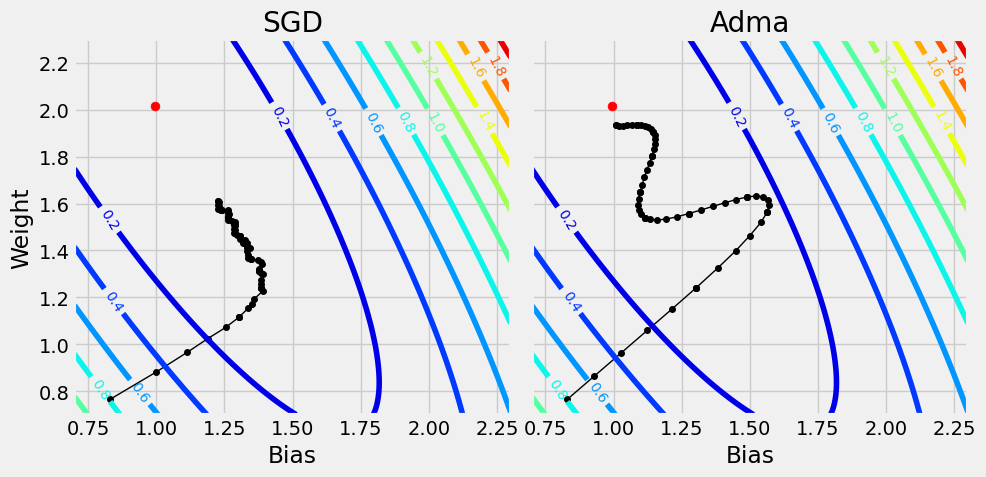

In [73]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

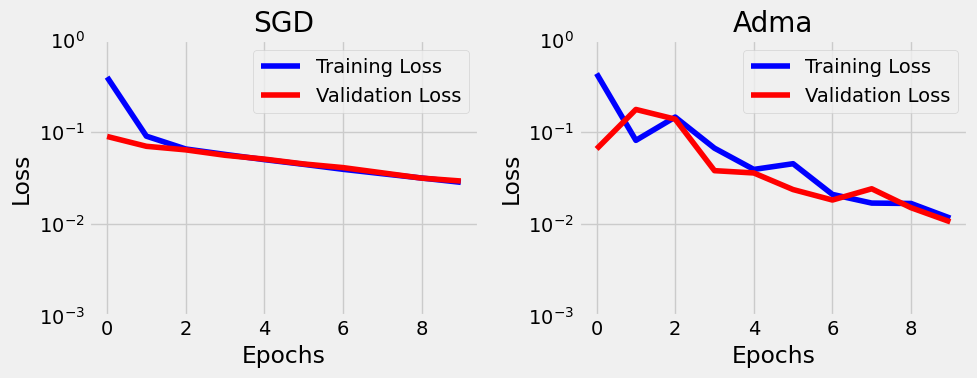

In [76]:
fig = plot_losses(results)

### Momentum

$$
\Large
\begin{array}{rcrcl}
\text{EWMA}_t &= &(1-\beta) \ \text{grad}_t &+ &\beta \ \text{EWMA}_{t-1}
\\
\text{momentum}_t &= & \ \text{grad}_t &+ &\beta \ \text{momentum}_{t-1}
\end{array}
$$

$$
\Large
\text{momentum}_t = \beta^0\ \text{grad}_t + \beta^1\ \text{grad}_{t-1} + \beta^2\ \text{grad}_{t-2} + \ldots + \beta^n\ \text{grad}_{t-n}
$$

$$
\Large \text{momentum}_t = (1-\text{damp})\ \text{grad}_t + \beta\ \text{momentum}_{t-1}
$$

$$
\Large
\begin{aligned}
\text{SGD}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{gradient}_t
\\
\text{Adam}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{adapted gradient}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{momentum}_t
\end{aligned}
$$

In [77]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': .1}}, 
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': .1, 'momentum': .9}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, layers_to_hook='linear', n_epochs=10)

In [81]:
results['SGD + Momentum']['state']

{'state': {0: {'momentum_buffer': tensor([[-0.1137]], device='cuda:0')},
  1: {'momentum_buffer': tensor([-0.3048], device='cuda:0')}},
 'param_groups': [{'lr': 0.1,
   'momentum': 0.9,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

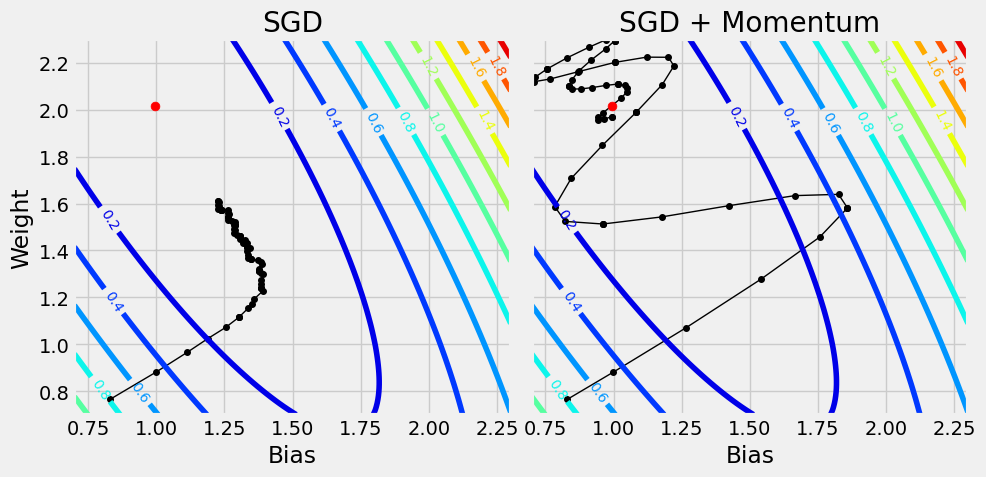

In [82]:
b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

#### Nesterov

$$
\Large
\begin{array}{rccrcl}
\text{step t}:   &                 &   & \text{mo}_t                               & = & \text{grad}_t + \beta \ \text{mo}_{t-1}
\\
\text{step t+1}: & \text{mo}_{t+1} & = & \text{grad}_{t+1} + \beta \ \text{mo}_{t} &
\end{array}
$$

$$
\Large
\begin{array}{rrclcrcc}
\text{step t}:   &                   &   &                   &   & \text{mo}_t           & = & \text{grad}_t \ + \ \beta \ \text{mo}_{t-1}
\\
\text{step t}:   & \text{nesterov}_t & = & \text{grad}_t     & + & \beta \ \text{mo}_t   &
\\
\text{step t+1}: & \text{mo}_{t+1}   & = & \text{grad}_{t+1} & + & \beta \ \text{mo}_{t} &
\end{array}
$$

$$
\Large
\begin{aligned}
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\end{aligned}
$$

$$
\Large
\begin{aligned}
\text{param}_t & = \text{param}_{t-1} - \eta\ \text{nesterov}_t
\\
& = \text{param}_{t-1} - \eta\ (\text{grad}_t + \beta\ \text{mo}_t)
\\
& = \text{param}_{t-1} - \eta\ \text{grad}_t - \beta\ \eta\ \text{mo}_t
\end{aligned}
$$

#### Flavors of SGD

$$
\Large
\begin{aligned}
\ \text{SGD}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t
\\
\text{SGD with Momentum}: &\text{param}_t = \text{param}_{t-1} &&& - & \ \ \ \eta\ \text{mo}_t
\\
\text{SGD with Nesterov}: &\text{param}_t = \text{param}_{t-1} &-& \eta\ \text{grad}_t & - & \beta \ \eta \ \text{mo}_t
\end{aligned}
$$

In [83]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': .1}}, 
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': .1, 'momentum': .9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': .1, 'momentum': .9, 'nesterov': True}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, layers_to_hook='linear', n_epochs=10)

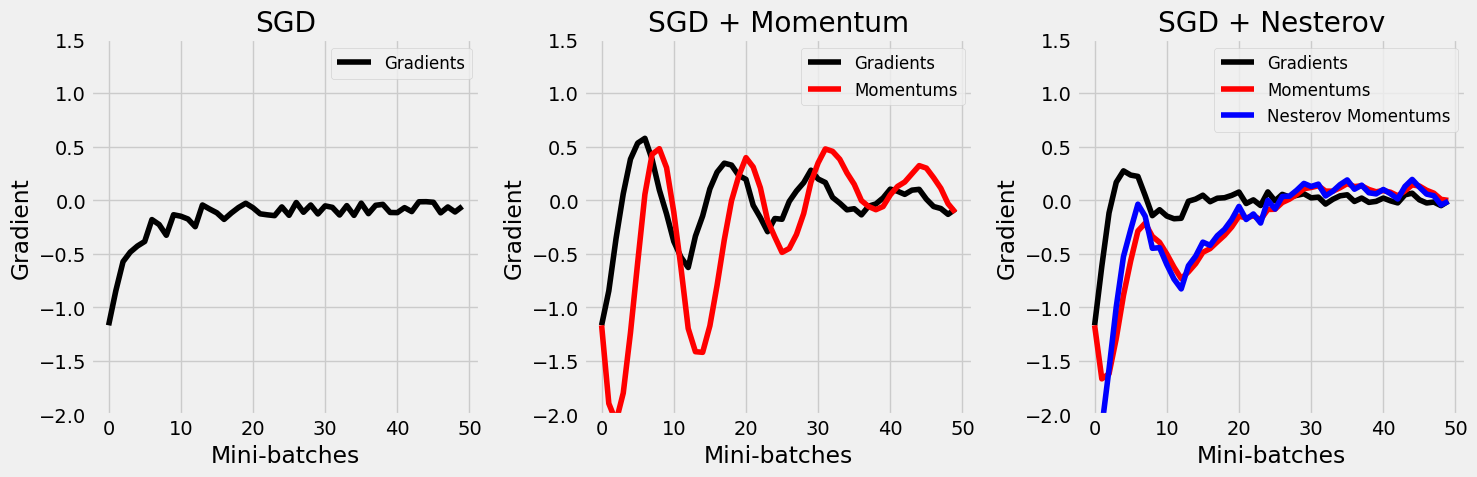

In [86]:
fig = figure21(results)

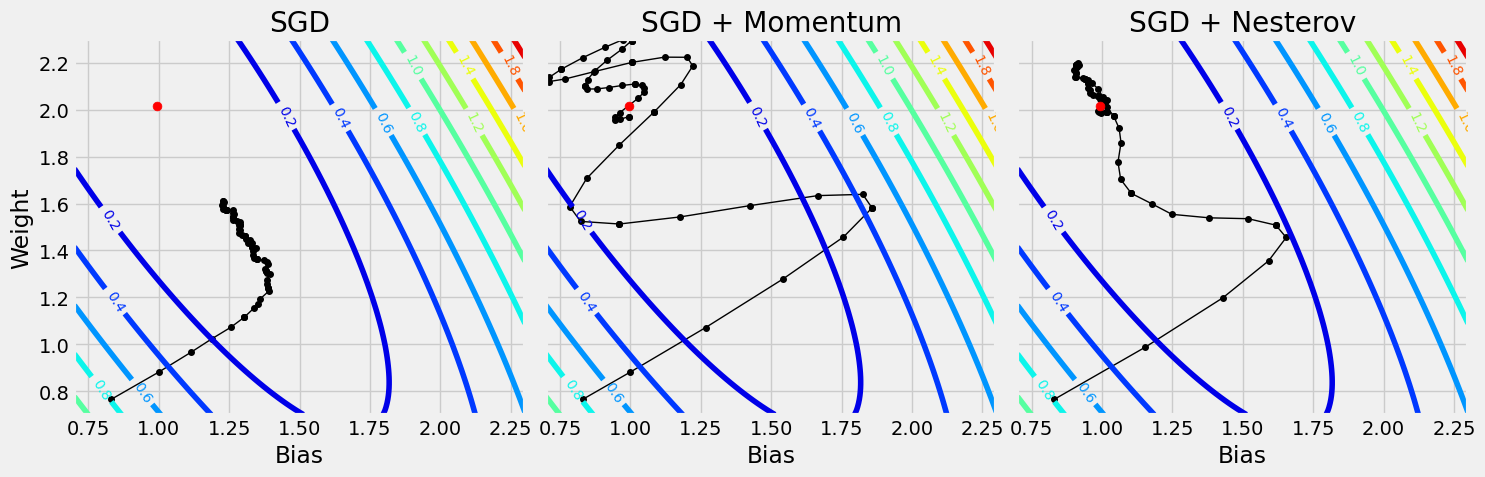

In [87]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

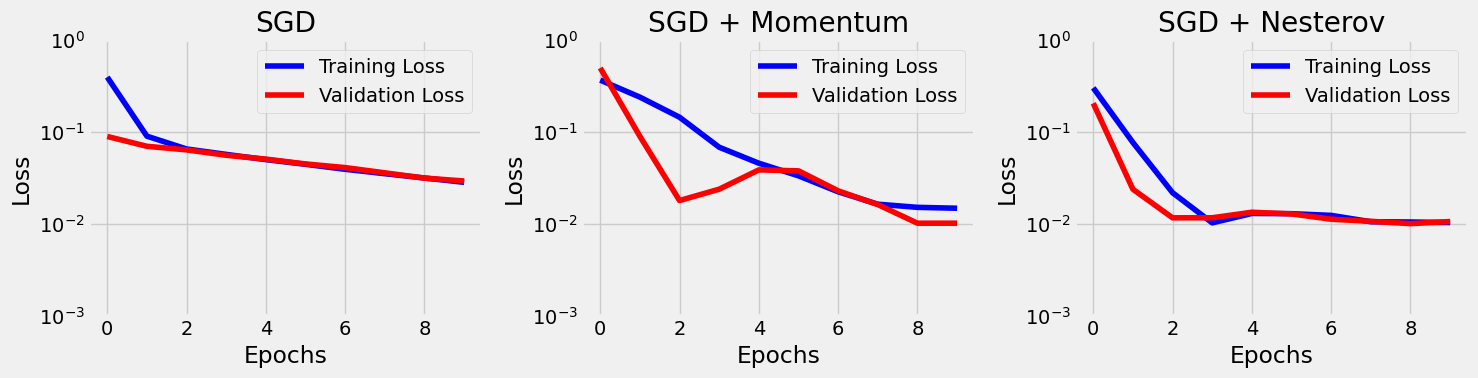

In [88]:
fig = plot_losses(results)

### Learning Rate Schedulers

In [90]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=.01)
dummy_scheduler = StepLR(optimizer=dummy_optimizer, step_size=2, gamma=.1)

In [91]:
for epoch in range(4):
    # trainin loop code goes here

    print(dummy_scheduler.get_last_lr())
    # First call optimizer's step
    dummy_optimizer.step()
    # Then call scheduler's step
    dummy_scheduler.step()

    dummy_optimizer.zero_grad()

[0.01]
[0.01]
[0.001]
[0.001]


### Epoch Schedulers

In [112]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch // 2))
# The scheduler above is equivalent to this one
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

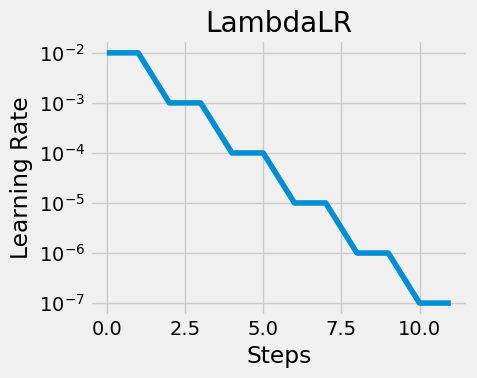

In [113]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Validation Loss Scheduler

In [123]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

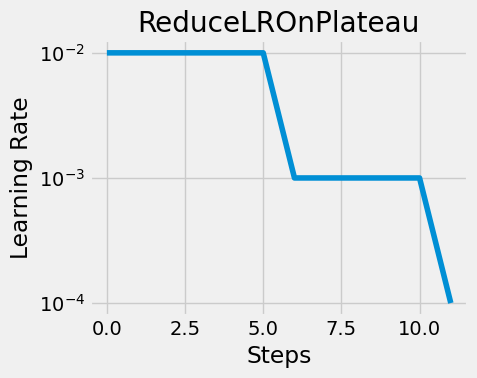

In [124]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

### Scheduler in StepByStep - Part I

In [ ]:
    #     self.scheduler = None
    #     self.is_batch_lr_scheduler = False


    # def set_lr_scheduler(self, scheduler):

In [ ]:
    # def _epoch_schedulers(self, metrics):

In [ ]:
    # def train(self, n_epochs, seed=42):

    #         # Call the learning rate scheduler
    #         self._epoch_schedulers(val_loss)

### Mini-Batch Schedulers

In [8]:
dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(0.5))

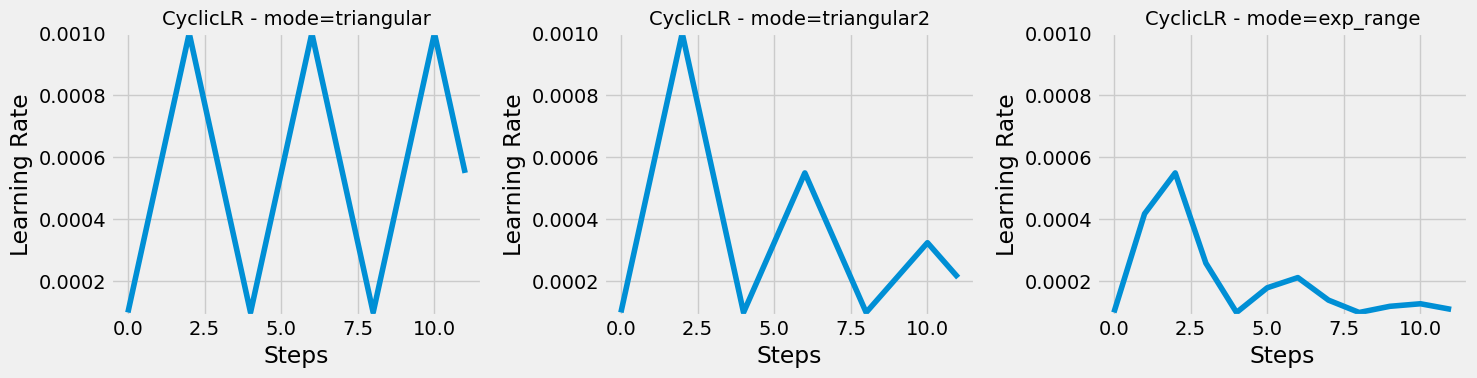

In [9]:
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

### Schedulers in StepByStep - Part II

In [ ]:
    # def _mini_batch_schedulers(self, frac_epoch):

In [ ]:
    # def _mini_batch(self, validation=False):

### Scheduler Paths

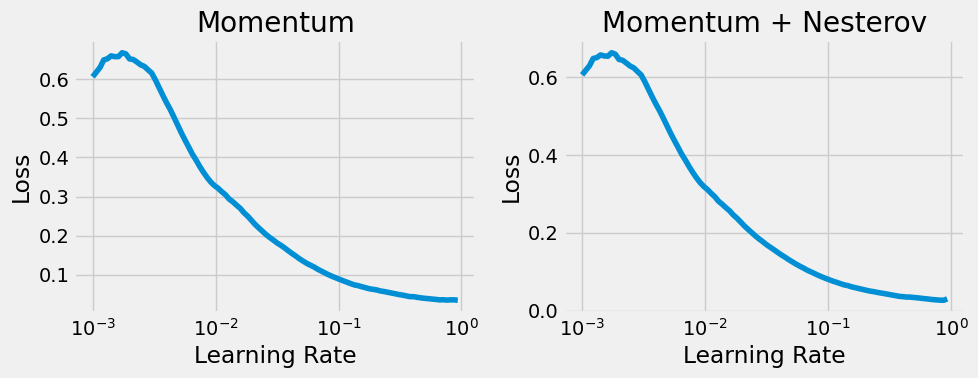

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = StepByStep(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, n_iter=100, ax=ax)

    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [22]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)

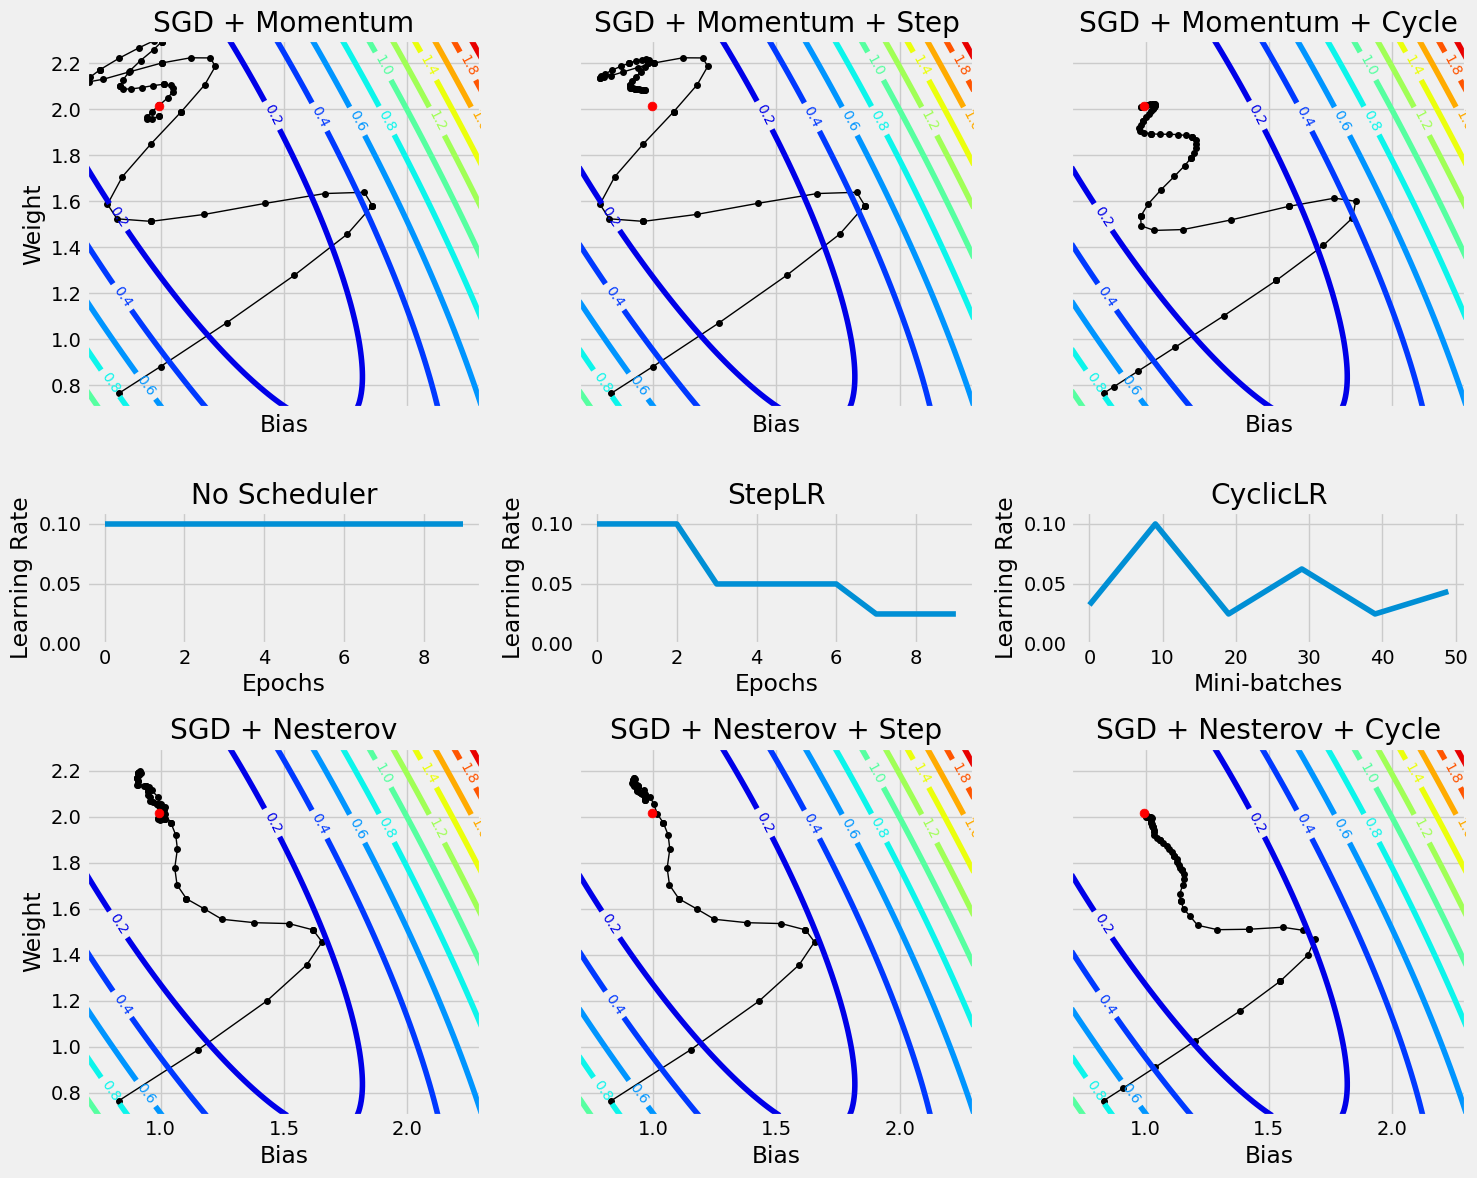

In [25]:
b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = figure28(results, b, w, bs, ws, all_losses)

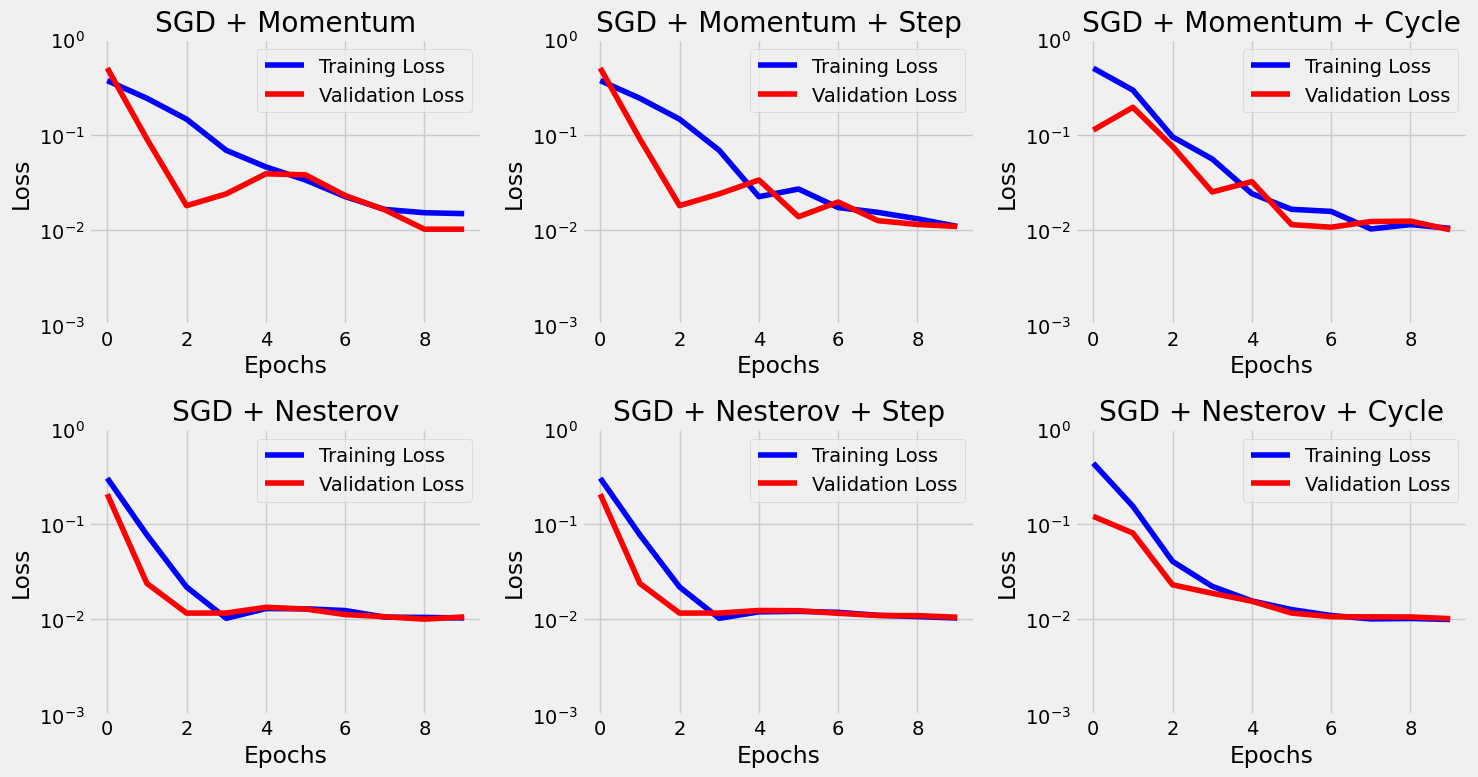

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)

# Putting It All Together

In [27]:
# Load temporary dataset to build normalizer
temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = StepByStep.make_normalizer(temp_loader)

# Build transformation, datasets and data loaders
composer = Compose([Resize(28),
                    ToImage(), 
                    ToDtype(torch.float32, scale=True),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Build a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [30]:
torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
ce_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

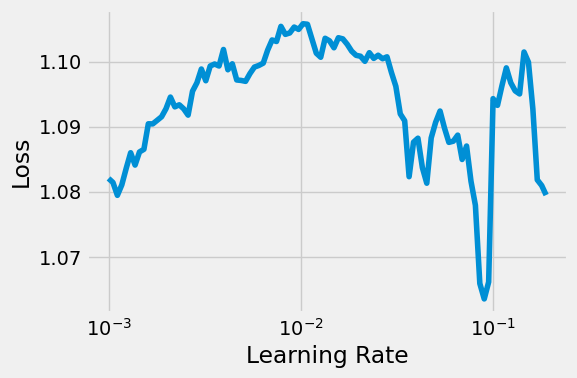

In [31]:
sbs_cnn3 = StepByStep(model_cnn3, ce_loss_fn, optimizer_cnn3)
tracking, fig = sbs_cnn3.lr_range_test(train_loader, end_lr=2e-1, n_iter=100)

In [32]:
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
sbs_cnn3.set_optimizer(optimizer_cnn3)

scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
sbs_cnn3.set_lr_scheduler(scheduler)

In [33]:
sbs_cnn3.set_loaders(train_loader, val_loader)
sbs_cnn3.train(10)

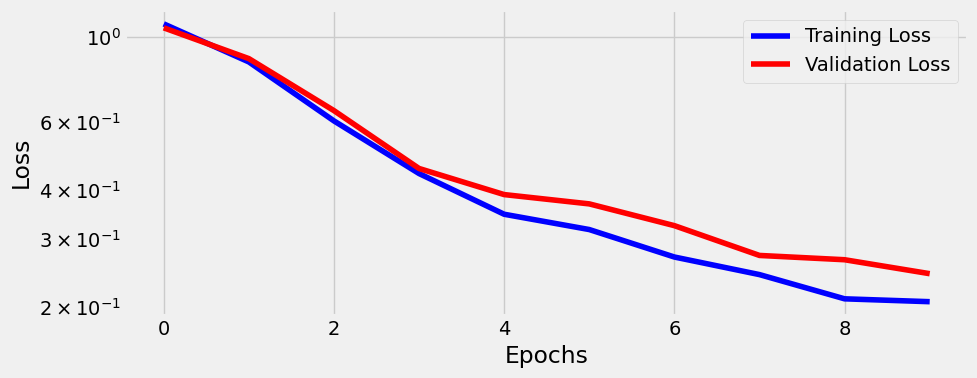

In [34]:
fig = sbs_cnn3.plot_losses()

In [35]:
print(StepByStep.loader_apply(train_loader, sbs_cnn3.correct).sum(axis=0), 
      StepByStep.loader_apply(val_loader, sbs_cnn3.correct).sum(axis=0))

tensor([2504, 2520]) tensor([336, 372])
